# Prompt Classification Model Training

This notebook implements the training pipeline for multiple classification models to identify domain-specific prompts. We compare different approaches:

## Models Evaluated
- **GPT-based classifier**: Using LLM for zero/few-shot classification
- **ModernBERT NLI**: Fine-tuned BERT model for Natural Language Inference
- **SVM**: Using different text embeddings (BAAI-BGE, MiniLM, TF-IDF)
- **XGBoost**: Using different text embeddings
- **FastText**: Specialized text classification model

## Domains
- Law
- Healthcare
- Finance

## Evaluation Metrics
- Accuracy
- Latency
- Cost (for LLM-based approaches)

In [1]:
import gc
import os
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from prompt_classifier.metrics import evaluate_run
from prompt_classifier.modeling.dspy_llm import LlmClassifier
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI
from prompt_classifier.util import create_domain_dataset, train_and_evaluate_model

load_dotenv()
random.seed(22)

## Hardware Acceleration

Check available ONNX Runtime providers for hardware acceleration (CPU/CUDA).
This affects the performance of embedding models and ModernBERT.

In [2]:
# Memory tracking
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")


def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

In [3]:
# Get list of available ONNX Runtime providers (CPU, CUDA etc.)
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


## Dataset Preparation

### Training Data Types
1. **Processed Data**: Clean, filtered dataset used for traditional ML models
2. **Interim Data**: Raw/intermediate data used for LLM experiments

Each domain dataset is balanced with positive samples from target domain and negative samples from other domains.

In [4]:
# Load processed datasets
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = create_domain_dataset(law_prompts, [healthcare_prompts, finance_prompts])

healthcare_dataset = create_domain_dataset(
    healthcare_prompts, [law_prompts, finance_prompts]
)

finance_dataset = create_domain_dataset(
    finance_prompts, [law_prompts, healthcare_prompts]
)

datasets = {
    "law": law_dataset,
    "healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [5]:
# Load interim datasets
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = create_domain_dataset(
    law_prompts_interim, [healthcare_prompts_interim, finance_prompts_interim]
)

healthcare_dataset_interim = create_domain_dataset(
    healthcare_prompts_interim, [law_prompts_interim, finance_prompts_interim]
)

finance_dataset_interim = create_domain_dataset(
    finance_prompts_interim, [law_prompts_interim, healthcare_prompts_interim]
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

## Initialize Embedding Models

Set up text embedding models:
- BAAI BGE Small
- MiniLM
- TF-IDF

In [6]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer(
    max_features=20_000,
)

2025-04-18 20:03:45.541441546 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-18 20:03:45.541479741 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-04-18 20:03:46.032022332 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-18 20:03:46.032055688 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-04-18 20:03:46.032022332 [W:onnxrun

In [7]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True  # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda


## Model Training and Evaluation

### LLM-based Models
First, we evaluate GPT and ModernBERT models using interim data:

In [ ]:
for domain, dataset in datasets_interim.items():
    # GPT Classifier
    train_data = dataset.sample(n=800)
    test_data = dataset.drop(train_data.index).sample(n=4000)
    """
    llm_classifier = LlmClassifier(
        api_key=os.getenv("OPENAI_API_KEY"),
        api_base=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )
    """
    llm_classifier = LlmClassifier(
        api_key="",
        api_base="http://localhost:11434",
        model_name="ollama_chat/qwen2.5:14b",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )
    try:
        # DSPy optimization
        llm_classifier.optimize_model()

        # Get predictions and metrics for test data
        test_predictions, test_actuals, test_latency = llm_classifier.predict()
        test_latency = statistics.mean(test_latency)

        test_acc = metrics.accuracy_score(test_actuals, test_predictions)

        # evaluate_run and save model
        evaluate_run(
            predictions=test_predictions,
            true_labels=test_actuals,
            domain=domain,
            model_name="qwen2.5:14b",
            embed_model="qwen-base",
            cost=llm_classifier.cost,
            latency=test_latency,
            train_acc=test_acc,
            training=True,
        )

        llm_classifier.save_model(f"models/qwen2.5:14b_{domain}.json")

    except Exception as e:
        print(f"Error running LLM model: {e}")

    # ModernBERT Classifier
    try:
        test_data = dataset.sample(n=30_000)
        bert_classifier = ModernBERTNLI(domain=domain)
        bert_classifier.classifier.model.to("cuda")

        # Test predictions
        test_predictions = []
        test_times = []
        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            start_time = time.perf_counter_ns()
            pred = bert_classifier.predict(row["prompt"])
            test_predictions.append(pred)
            test_times.append(time.perf_counter_ns() - start_time)

        print(test_predictions)
        test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
        mean_prediction_time = statistics.mean(test_times)

        # evaluate_run ModernBERT
        evaluate_run(
            predictions=test_predictions,
            true_labels=test_data["label"],
            domain=domain,
            model_name="modernbert",
            embed_model="bert-base",
            latency=mean_prediction_time,
            train_acc=test_acc,
            training=True,
        )
    except Exception as e:
        print(f"Error running ModernBERT model: {e}")

### Traditional ML Models

Evaluate SVM, XGBoost and FastText using processed data with different embedding approaches:
- BAAI-BGE: Dense semantic embeddings
- MiniLM: Lightweight sentence embeddings
- TF-IDF: Sparse word frequency embeddings
- FastText: Custom subword embeddings

Models are trained on 70% of data and evaluated on remaining 30%.

In [8]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [9]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']


Processing domain: law
Skipping law domain until healthcare
Processing domain: healthcare


Progress: 100.0% Trials:   23 Best score:  0.995000 ETA:   0h 0m 0s
Training again with best arguments
Progress: 100.0% Trials:   23 Best score:  0.995000 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  85160
Number of labels: 2
Read 1M words
Number of words:  85160
Number of labels: 2
Progress: 100.0% words/sec/thread: 2048470 lr:  0.000000 avg.loss:  0.029819 ETA:   0h 0m 0s
Progress: 100.0% words/sec/thread: 2048470 lr:  0.000000 avg.loss:  0.029819 ETA:   0h 0m 0s
100%|██████████| 9000/9000 [00:00<00:00, 16355.70it/s]



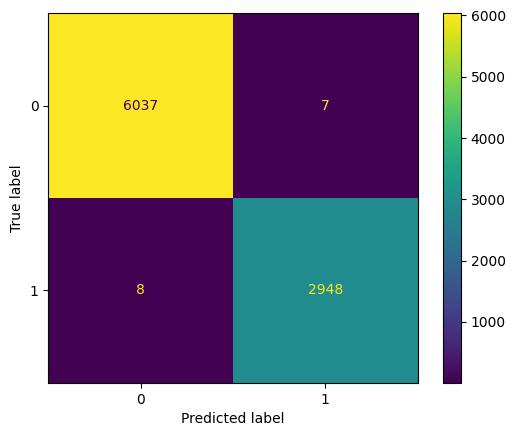

Healthcare fastText complete - continuing with remaining models
Processing domain: finance
SVM
<class 'numpy.ndarray'>
Training mini embeddings on finance domain using SVM
SVM
<class 'numpy.ndarray'>
Training mini embeddings on finance domain using SVM
Cross-validation accuracy: 0.9947222222222223 ± 0.0016782008296659066
Cross-validation accuracy: 0.9947222222222223 ± 0.0016782008296659066


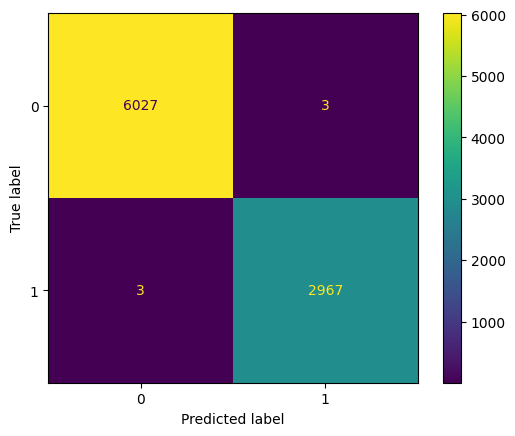

XGB
<class 'numpy.ndarray'>
Training mini embeddings on finance domain using XGBoost
Cross-validation accuracy: 0.9930555555555556 ± 0.001521451548625456
Cross-validation accuracy: 0.9930555555555556 ± 0.001521451548625456


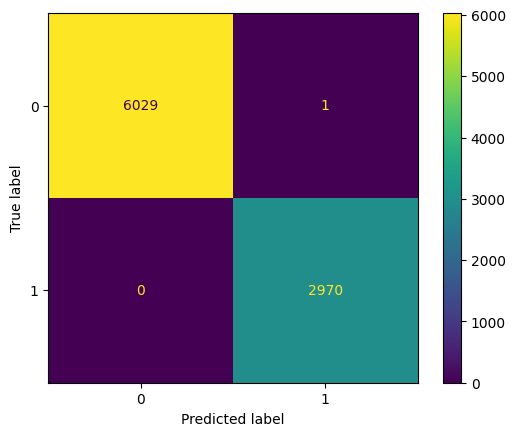

SVM
<class 'scipy.sparse._csr.csr_matrix'>
Training tf_idf embeddings on finance domain using SVM
Cross-validation accuracy: 0.9754166666666666 ± 0.004762896722078385
Cross-validation accuracy: 0.9754166666666666 ± 0.004762896722078385


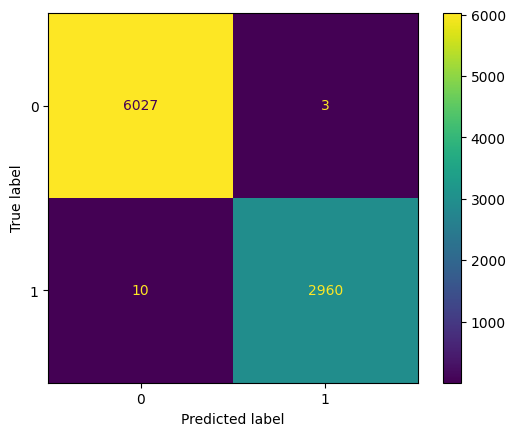

XGB
<class 'scipy.sparse._csr.csr_matrix'>
Training tf_idf embeddings on finance domain using XGBoost
Cross-validation accuracy: 0.9759722222222222 ± 0.004681194318431293
Cross-validation accuracy: 0.9759722222222222 ± 0.004681194318431293


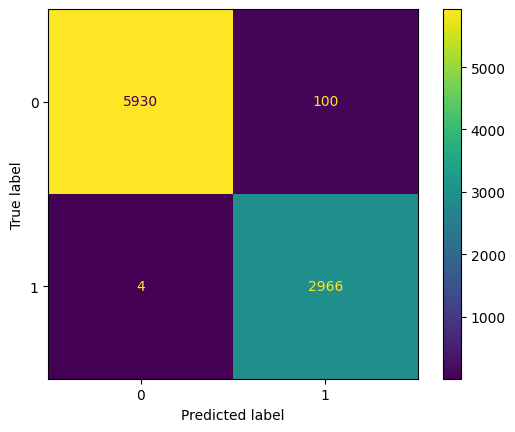

SVM
<class 'numpy.ndarray'>
Training baai embeddings on finance domain using SVM
Cross-validation accuracy: 0.9969444444444445 ± 0.0003402069087198846
Cross-validation accuracy: 0.9969444444444445 ± 0.0003402069087198846


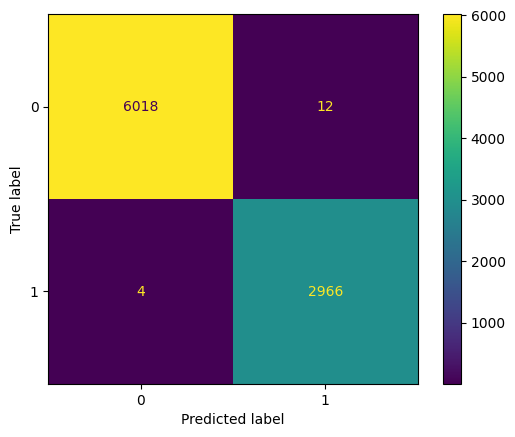

XGB
<class 'numpy.ndarray'>
Training baai embeddings on finance domain using XGBoost
Cross-validation accuracy: 0.9902777777777778 ± 0.0019641855032959585
Cross-validation accuracy: 0.9902777777777778 ± 0.0019641855032959585


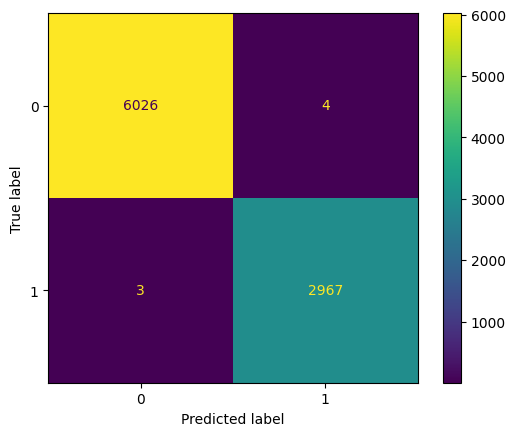

Progress: 100.0% Trials:   15 Best score:  0.994722 ETA:   0h 0m 0s
Training again with best arguments
Progress: 100.0% Trials:   15 Best score:  0.994722 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  85164
Number of labels: 2
Read 1M words.2% words/sec/thread:  399646 lr:  0.053602 avg.loss:  0.694124 ETA:   0h 1m 1s
Number of words:  85164
Number of labels: 2
Progress: 100.0% words/sec/thread:  415340 lr:  0.000000 avg.loss:  0.011992 ETA:   0h 0m 0s  0.6% words/sec/thread:  388826 lr:  0.053350 avg.loss:  0.689310 ETA:   0h 1m 3s  0.6% words/sec/thread:  388826 lr:  0.053350 avg.loss:  0.689310 ETA:   0h 1m 3sProgress:  76.1% words/sec/thread:  414244 lr:  0.012849 avg.loss:  0.014968 ETA:   0h 0m14s
Progress: 100.0% words/sec/thread:  415340 lr:  0.000000 avg.loss:  0.011992 ETA:   0h 0m 0s
100%|██████████| 9000/9000 [00:01<00:00, 8665.97it/s]



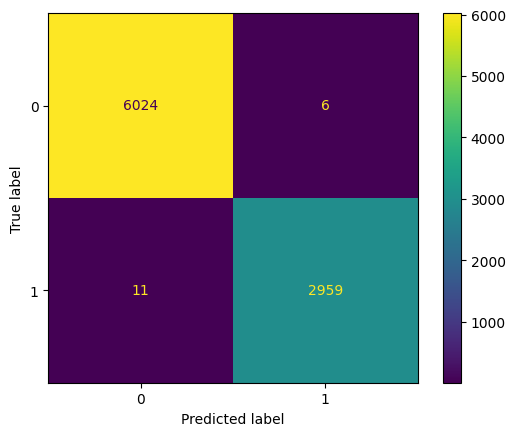

In [10]:
skip_until_healthcare = True

for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.8).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # Skip embedding models if we're waiting for healthcare fastText
    if not skip_until_healthcare:
        for model_name, embedding_model in embedding_models.items():
            embed_times: float = None

            # Add timing for embedding creation
            if model_name == "tf_idf":
                # Fit on training data only
                embedding_model.fit(train_data["prompt"])

                with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                    pickle.dump(embedding_model, f)

                start_time = time.perf_counter_ns()
                # Convert sparse matrices to dense for consistency
                train_embeds = embedding_model.transform(train_data["prompt"])
                test_embeds = embedding_model.transform(test_data["prompt"])
                end_time = time.perf_counter_ns()
                embed_times = end_time - start_time
            else:
                # Time the embedding process for training data
                start_time = time.perf_counter_ns()
                train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
                test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))
                end_time = time.perf_counter_ns()
                embed_times = end_time - start_time

            mean_embed_time = embed_times / len(train_data + test_data)

            try:
                # Train and evaluate SVM model
                train_and_evaluate_model(
                    model_name="SVM",
                    train_embeds=train_embeds,
                    test_embeds=test_embeds,
                    train_labels=train_data["label"],
                    test_labels=test_data["label"],
                    domain=domain,
                    embed_model=model_name,
                    save_path=f"models/SVM_{domain}_{model_name}.pkl",
                    embedding_time=mean_embed_time,
                    training=True,
                )
            except Exception as e:
                print(f"Error running SVM model: {e}")

            try:
                # Train and evaluate XGBoost model
                train_and_evaluate_model(
                    model_name="XGBoost",
                    train_embeds=train_embeds,
                    test_embeds=test_embeds,
                    train_labels=train_data["label"],
                    test_labels=test_data["label"],
                    domain=domain,
                    embed_model=model_name,
                    save_path=f"models/XGBoost_{domain}_{model_name}.json",
                    embedding_time=mean_embed_time,
                    training=True,
                )
            except Exception as e:
                print(f"Error running XGBoost model: {e}")

    # fastText
    try:
        fasttext_classifier = FastTextClassifier(
            train_data=train_data, test_data=test_data
        )
        fasttext_classifier.train()

        train_predictions = []
        for _, row in train_data.iterrows():
            query = str(row["prompt"]).replace("\n", "")
            prediction = fasttext_classifier.model.predict(query)
            train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

        train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            text = str(row["prompt"])
            query = text.replace("\n", "")

            start_time = time.perf_counter_ns()
            prediction = fasttext_classifier.model.predict(query)
            end_time = time.perf_counter_ns()

            prediction_times.append(end_time - start_time)

            if prediction[0][0] == "__label__1":
                predictions.append(1)
            else:
                predictions.append(0)

            actuals.append(row["label"])

        mean_prediction_time = statistics.mean(prediction_times)

        evaluate_run(
            predictions,
            true_labels=actuals,
            domain=domain,
            model_name="fastText",
            embed_model="fastText",
            latency=mean_prediction_time,
            train_acc=train_acc,
            training=True,
        )

        fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")

    except Exception as e:
        print(f"Error running fastText model: {e}")